In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import time
import copy
import wandb
import argparse
from pathlib import Path
from datetime import datetime
from omegaconf import OmegaConf

import numpy as np
import torch
from utils.utils import extract_trailing_numbers, seed_everything

import flowmol

In [3]:
def sampling(
        config: OmegaConf,
        model: flowmol.FlowMol,
        xt_traj: bool = False,
        ep_traj: bool = False, 
        device: torch.device = None
    ):
    new_molecules = model.sample_random_sizes(
        n_molecules = config.num_samples, 
        n_timesteps = config.num_integration_steps,
        xt_traj=xt_traj,
        ep_traj=ep_traj,
        device = device,
    )
    return new_molecules


In [4]:
def setup_gen_model(flow_model: str, device: torch.device):
    # Load - Flow Model
    gen_model = flowmol.load_pretrained(flow_model)
    gen_model.to(device)
    return gen_model

In [5]:
def parse_args():
    parser = argparse.ArgumentParser(description="Run ALM with optional parameter overrides")
    # Settings
    parser.add_argument("--config", type=str, default="configs/adjoint_matching.yaml",
                        help="Path to config file")
    parser.add_argument("--use_wandb", action='store_true',
                        help="Use wandb, default: false")
    parser.add_argument("--verbose", action='store_true', 
                        help="Verbose output, default: false")
    parser.add_argument("--save_model", action='store_true',
                        help="Save the model, default: false")
    parser.add_argument("--save_samples", action='store_true',
                        help="Create animation of the samples and save the samples, default: false")
    parser.add_argument("--save_plots", action='store_true',
                        help="Save plots of rewards and constraints, default: false")
    parser.add_argument("--plotting_freq", type=int,
                        help="Plotting frequency")
    # FlowMol arguments
    flowmol_choices = ['qm9_ctmc', 'qm9_gaussian', 'qm9_simplexflow', 'qm9_dirichlet']
    parser.add_argument('--flow_model', type=str, choices=flowmol_choices,
                        help='pretrained model to be used')
    parser.add_argument("--reward_lambda", type=float,
                        help="Override reward_lambda in config")
    parser.add_argument("--lr", type=float,
                        help="Override adjoint_matching.lr in config")
    parser.add_argument("--clip_grad_norm",  type=float,
                        help="Override adjoint_matching.clip_grad_norm in config")
    parser.add_argument("--batch_size", type=int,
                        help="Override adjoint_matching.batch_size in config")
    parser.add_argument("--samples_per_update", type=int,
                        help="Override adjoint_matching.num_samples in config")
    parser.add_argument("--num_integration_steps", type=int,
                        help="Override adjoint_matching.num_integration_steps in config")
    parser.add_argument("--finetune_steps", type=int,
                        help="Override adjoint_matching.finetune_steps in config")
    parser.add_argument("--num_iterations", type=int,
                        help="Override number of iterations")
    return parser.parse_args()

In [6]:
import sys
sys.argv = [""]

In [7]:
def update_config_with_args(config, args):
    # FlowMol arguments
    if args.flow_model is not None:
        config.flowmol.model = args.flow_model
    # Adjoint Matching Parameters
    if args.reward_lambda is not None:
        config.reward_lambda = args.reward_lambda
    if args.lr is not None:
        config.adjoint_matching.lr = args.lr
    if args.clip_grad_norm is not None:
        config.adjoint_matching.clip_grad_norm = args.clip_grad_norm
    if args.batch_size is not None:
        config.adjoint_matching.batch_size = args.batch_size
    if args.samples_per_update is not None:
        config.adjoint_matching.sampling.num_samples = args.samples_per_update
    if args.num_integration_steps is not None:
        config.adjoint_matching.sampling.num_integration_steps = args.num_integration_steps
    if args.finetune_steps is not None:
        config.adjoint_matching.finetune_steps = args.finetune_steps
    if args.num_iterations is not None:
        config.adjoint_matching.num_iterations = args.num_iterations
    return config

In [ ]:
# Parse command line arguments
args = parse_args()

# Load config from file
config_path = Path(args.config)
config = OmegaConf.load(config_path)

# Update config with command line arguments
config = update_config_with_args(config, args)

# Setup - Seed and device and root directory
seed_everything(config.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = Path(config.root) / Path(config.dataset)

# Settings
config.verbose = args.verbose
if args.plotting_freq is None:
    args.plotting_freq = config.adjoint_matching.num_iterations // 20

# General Parameters
flowmol_model = config.flow_model
dataset = config.dataset

# Adjoint Matching Parameters
reward_lambda = config.reward_lambda
learning_rate = config.adjoint_matching.lr
clip_grad_norm = config.adjoint_matching.clip_grad_norm
traj_samples_per_stage = config.adjoint_matching.sampling.num_samples
traj_len = config.adjoint_matching.sampling.num_integration_steps
finetune_steps = config.adjoint_matching.finetune_steps
num_iterations = config.adjoint_matching.num_iterations

config.adjoint_matching.sampling.sampler_type = "memoryless"
config.reward_sampling.sampler_type = "euler"

print(f"--- Start ---", flush=True)
# Setup - WandB
if args.use_wandb:
    wandb.init()
    run_name = wandb.run.name  # e.g., "olive-sweep-229"
    run_number = extract_trailing_numbers(run_name)  # e.g., 229
    run_id = wandb.run.id   # e.g., "ame6uc42"
    sweep_id = wandb.run.sweep_id if wandb.run.sweep_id else "No_sweep"
    print(f"Run #{run_number} - ID: {run_id}", flush=True)

# Prints
print(f"Finetuning {flowmol_model} on {dataset}", flush=True)
start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Start time: {start_time}", flush=True)
print(f"Device: {device}", flush=True)
start_time = time.time()

print(f"--- Config ---", flush=True)

print(f"Adjoint Matching Parameters", flush=True)
print(f"\treward_lambda: {reward_lambda}", flush=True)
print(f"\tlr: {learning_rate}", flush=True)
print(f"\tclip_grad_norm: {clip_grad_norm}", flush=True)
print(f"\tsampling.num_samples: {traj_samples_per_stage}", flush=True)
print(f"\tsampling.num_integration_steps: {traj_len}", flush=True)
print(f"\tfinetune_steps: {finetune_steps}", flush=True)
print(f"\tnum_iterations: {num_iterations}", flush=True)

--- Start ---
Finetuning qm9_ctmc on QM9
Start time: 2025-04-23 11:32:06
Device: cpu
--- Config ---
Adjoint Matching Parameters
	reward_lambda: 100000
	lr: 5e-06
	clip_grad_norm: 0.7
	sampling.num_samples: 100
	sampling.num_integration_steps: 40
	finetune_steps: 5
	num_iterations: 400


In [67]:
config.reward_sampling.num_samples = 3

In [10]:
# Setup - Gen Model
gen_model = setup_gen_model(config.flow_model, device=device)

In [11]:
config.reward_sampling

{'sampler_type': 'euler', 'num_samples': 5, 'data_dim': 2, 'num_integration_steps': 40}

In [ ]:
# # Generate Samples
# x_new = sampling(
#     config.reward_sampling,
#     copy.deepcopy(gen_model),
#     device=device
# )

/opt/homebrew/Caskroom/miniforge/base/envs/deep/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [79]:
# Generate Samples
x_new_tr = sampling(
    config.reward_sampling,
    copy.deepcopy(gen_model),
    xt_traj=True,
    # ep_traj=True,
    device=device
)

tensor([18, 18, 15])
edge_idxs_dict: {15: tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
          6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
          9,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 12, 12, 13,  1,  2,  3,
          4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  2,  3,  4,  5,  6,  7,  8,
          9, 10, 11, 12, 13, 14,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
          4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  5,  6,  7,  8,  9, 10, 11,
         12, 13, 14,  6,  7,  8,  9, 10, 11, 12, 13, 14,  7,  8,  9, 10, 11, 12,
         13, 14,  8,  9, 10, 11, 12, 13, 14,  9, 10, 11, 12, 13, 14, 10, 11, 12,
         13, 14, 11, 12, 13, 14, 12, 13, 14, 13, 14, 14],
        [

AssertionError: 

In [69]:
x_new_tr

In [ ]:
x_new_tr

In [73]:
sample_tr = x_new_tr[1]

In [118]:
k = 10

In [119]:
x = steps = 6

In [130]:
import numpy as np

idx = np.random.choice(k, size=x, replace=True)
idx



array([7, 3, 1, 5, 5, 9])

In [139]:
losses = [i for i in range(1,10)]
losses

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [140]:
losses.insert(0,losses[0])
losses

[1, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [137]:
type(losses)

NoneType

In [114]:
g_t = sample_tr.g
g_t

Graph(num_nodes=23, num_edges=506,
      ndata_schemes={'x_0': Scheme(shape=(3,), dtype=torch.float32), 'a_0': Scheme(shape=(6,), dtype=torch.float32), 'c_0': Scheme(shape=(7,), dtype=torch.float32), 'x_t': Scheme(shape=(3,), dtype=torch.float32), 'a_t': Scheme(shape=(6,), dtype=torch.float32), 'c_t': Scheme(shape=(7,), dtype=torch.float32), 'x_1_pred': Scheme(shape=(3,), dtype=torch.float32), 'a_1_pred': Scheme(shape=(6,), dtype=torch.float32), 'c_1_pred': Scheme(shape=(7,), dtype=torch.float32), 'x_1': Scheme(shape=(3,), dtype=torch.float32), 'a_1': Scheme(shape=(6,), dtype=torch.float32), 'c_1': Scheme(shape=(7,), dtype=torch.float32)}
      edata_schemes={'e_0': Scheme(shape=(6,), dtype=torch.float32), 'e_t': Scheme(shape=(6,), dtype=torch.float32), 'e_1_pred': Scheme(shape=(6,), dtype=torch.float32), 'e_1': Scheme(shape=(6,), dtype=torch.float32), 'ue_mask': Scheme(shape=(), dtype=torch.bool)})

In [117]:
g_t.edata

{'e_0': tensor([[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.]]), 'e_t': tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]]), 'e_1_pred': tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]]), 'e_1': tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]]), 'ue_mask': tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
 

In [ ]:
g_t

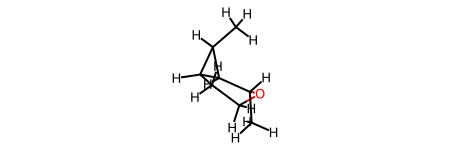

In [74]:
sample_tr.rdkit_mol

In [75]:
for k, v in sample_tr.traj_frames.items():
    print(k)
    print(v.shape)

x
torch.Size([40, 23, 3])
x_1_pred
torch.Size([39, 23, 3])
a
torch.Size([40, 23, 6])
a_1_pred
torch.Size([39, 23, 6])
c
torch.Size([40, 23, 7])
c_1_pred
torch.Size([39, 23, 7])
e
torch.Size([40, 506, 6])
e_1_pred
torch.Size([39, 506, 6])


In [102]:
import torch
import dgl
from flowmol.data_processing.utils import build_edge_idxs

def build_graphs_from_traj(traj_frames):
    x = traj_frames['x']       # [T, N, 3]
    a = traj_frames['a']       # [T, N, 6]
    c = traj_frames['c']       # [T, N, 7]
    e = traj_frames['e']       # [T, E, 6]
    
    T, N, _ = x.shape
    _, E, _ = e.shape

    graphs = []
    for t in range(T):
        edge_idx = build_edge_idxs(N)  # assumed to return a tuple (src, dst) each of shape [E]

        g = dgl.graph((edge_idx[0],edge_idx[1]), num_nodes=N)

        g.ndata['x'] = x[t]       # [N, 3]
        g.ndata['a'] = a[t]      # [N, 6]
        g.ndata['c'] = c[t]    # [N, 7]
        g.edata['e'] = e[t]      # [E, 6]

        graphs.append(g)
    
    return graphs


In [103]:
graphs = build_graphs_from_traj(sample_tr.traj_frames)

In [104]:
graphs[0]

Graph(num_nodes=23, num_edges=506,
      ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32), 'a': Scheme(shape=(6,), dtype=torch.float32), 'c': Scheme(shape=(7,), dtype=torch.float32)}
      edata_schemes={'e': Scheme(shape=(6,), dtype=torch.float32)})

In [ ]:
graphs[0].ndata['x']

tensor([5.1830e-08, 3.6281e-08, 2.5915e-09])